# Atom Clustering and Cluster Modelling

This tutorial shows how objects in space may be analyzed via clustering. This post-processing step can be taken after atoms, e.g. as obtained from molecular dynamics simulations, are classified to understand the patterns in their distribution. A further post-processing step of interest is the modelling of cluster-size distributions and their temporal evolution. This is modelled below using the diffusion equation motivated by the Becker-Doehring theory.

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
from scipy.cluster import hierarchy
import numpy
from scipy import stats
from scipy.linalg import toeplitz
import numpy as np
import atomtoolbox as atb
import collections
import pymc3 as pm
from theano import shared
import theano.tensor as tt

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Cluster Atoms in Space

To get a feeling for clustering algorithms we generate some clusters of atoms / points in a 2D space and associate atoms with those clusters. To identify these clusters of atoms we use a hierarchical clustering algorithm as implemented in scipy. Note that other approaches, e.g. k-means or density approximating methods could also be used. Hierarchical clustering is used here since this allows for the generation of dendrograms, which is useful for analysis.

### 1.1 Generate Atoms

<IPython.core.display.Javascript object>


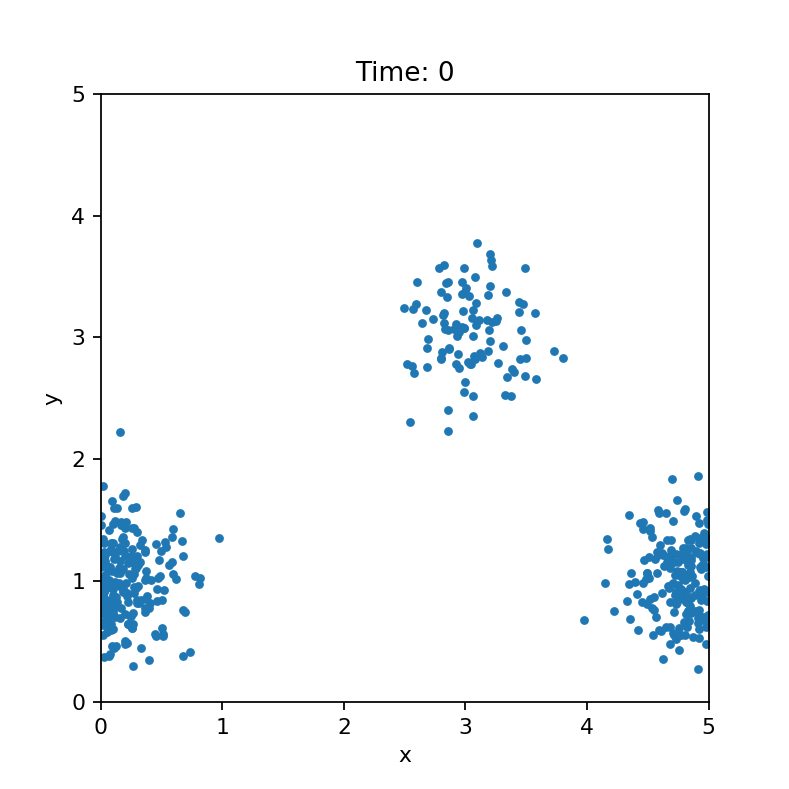

<IPython.core.display.Javascript object>


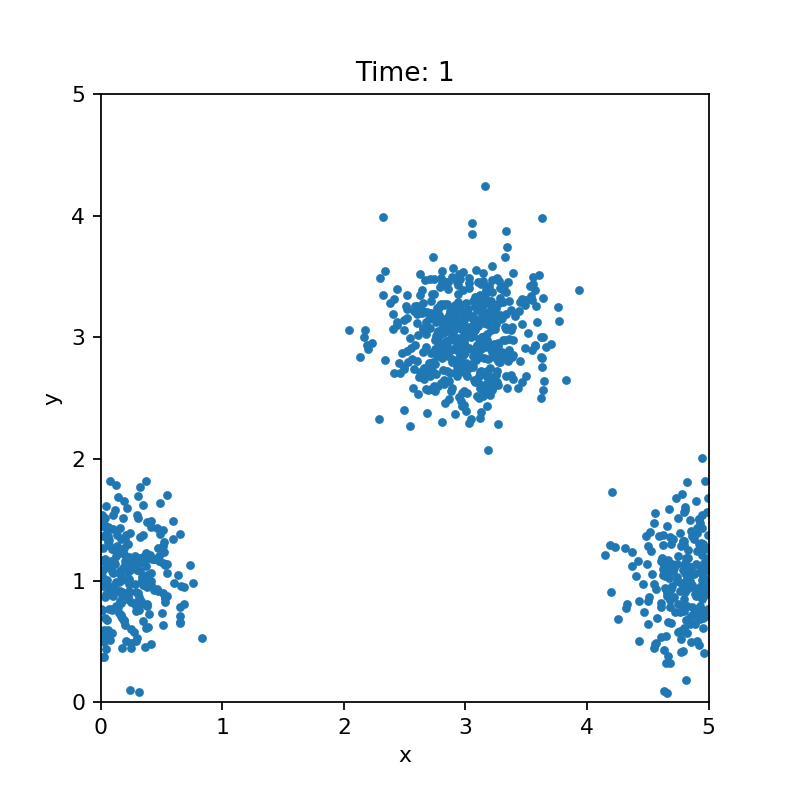

In [2]:
# the random variables the positions will be drawn from
rvs = [stats.multivariate_normal(mean=[0,1], cov=[[.1,0],[0,.1]]),
       stats.multivariate_normal(mean=[3,3], cov=[[.1,0],[0,.1]]),]

# the number of positions to draw from each rv each timestep
Natoms = [[402,101],[470,500]]

# timesteps
N = 2

# boxes
all_box = [np.array([[0,5],[0,5]]),
           np.array([[0,5],[0,5]]),]

all_pos = []
for j in range(N):
    
    _pos = None
    box = all_box[j]
    
    for i in range(len(rvs)):
        if _pos is None:
            _pos = rvs[i].rvs(size=Natoms[j][i])
        else:
            _pos = np.vstack((_pos, rvs[i].rvs(size=Natoms[j][i])))
    
    _pos = atb.wrap_lammps_pos(_pos,box)
    all_pos.append(_pos)

for i, _pos in enumerate(all_pos):
    box = all_box[i]
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.plot(_pos[:,0], _pos[:,1],'.')
    ax.set_xlim(box[0])
    ax.set_ylim(box[1])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Time: "+str(i))
    plt.show()

### 1.2 Compute Clusters Hierarchically

<IPython.core.display.Javascript object>


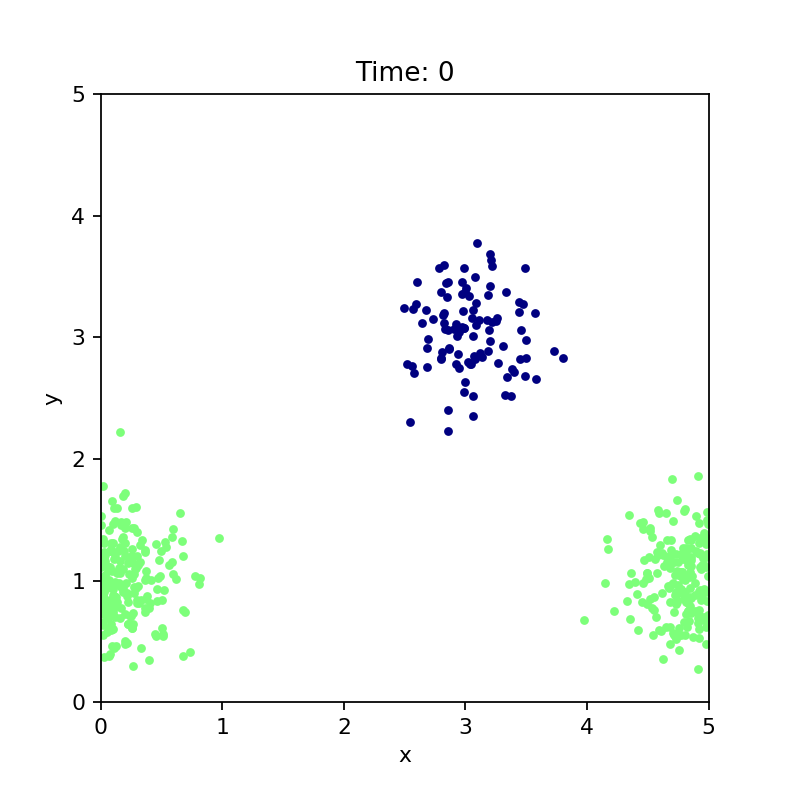

<IPython.core.display.Javascript object>


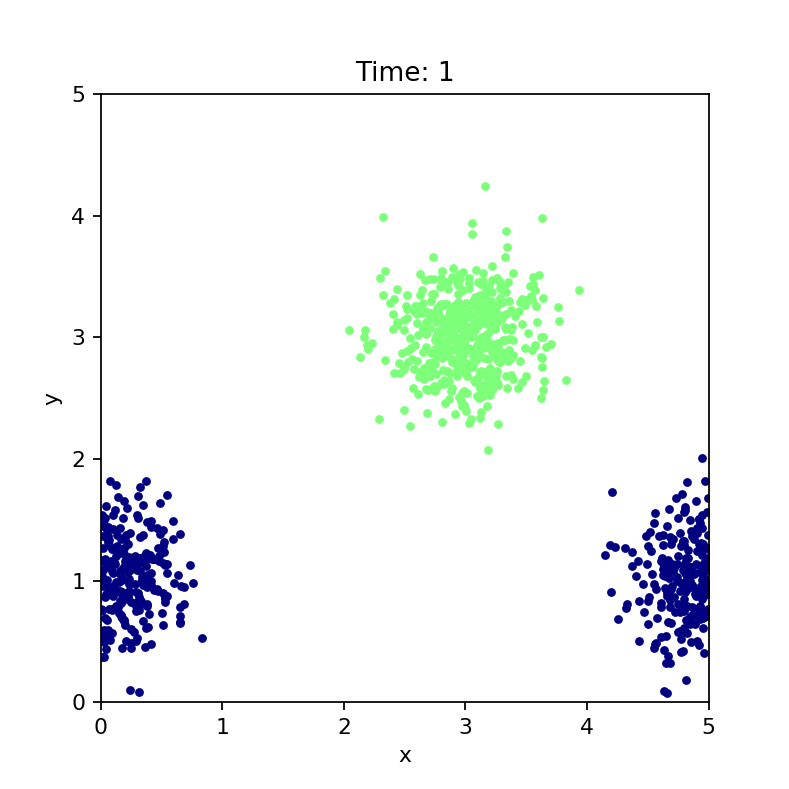

In [3]:
clustering_distance = .5 # [Ang]
cluster_label = "gamma_prime"

all_cluster_statistics = []
for i,pos in enumerate(all_pos):
    #idx = np.where(all_classes[i] == cluster_label)[0]
    #pos = pos[idx,:]
    box = all_box[i]
    
    fdata = atb.fclusterdata(pos, clustering_distance, box, criterion='distance', 
                         metric='euclidean', method='single', 
                         compute_inconsistency=True)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    classes = np.unique(fdata)
    for j,c in enumerate(classes):
        _pos = pos[fdata==c,:]
        ax.plot(_pos[:,0], _pos[:,1], '.',color=plt.cm.jet(j/float(len(classes))))
    ax.set_xlim(box[0])
    ax.set_ylim(box[1])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Time: "+str(i))
    plt.show()
    
    cluster_statistics = collections.Counter(fdata).most_common() #(frequency, number of atoms)
    all_cluster_statistics.append(cluster_statistics)

## 2. Cluster-Size Distribution

### 2.1 Create Cluster-Size Distributions

Next, we simulate the evolution of a cluster size distribution via Monte-Carlo by defining a transition matrix.


cluster_sizes:
 [0 1 2 3 4 5 6]

initial_distribution:
 [ 1.  0.  0.  0.  0.  0.  0.]

Transition matrix:
 [[ 0.75  0.25  0.    0.    0.    0.    0.  ]
 [ 0.25  0.5   0.25  0.    0.    0.    0.  ]
 [ 0.    0.25  0.5   0.25  0.    0.    0.  ]
 [ 0.    0.    0.25  0.5   0.25  0.    0.  ]
 [ 0.    0.    0.    0.25  0.5   0.25  0.  ]
 [ 0.    0.    0.    0.    0.25  0.5   0.25]
 [ 0.    0.    0.    0.    0.    0.25  0.75]]

eigenvalues:
 [ 0.04951557  0.1882551   0.38873953  0.61126047  0.8117449   1.
  0.95048443]

second largest eigenvalue:  0.950484433951  delta =  19.6914375822

eigenvectors:
 [[  1.18942442e-01   2.31920614e-01  -3.33269318e-01   4.17906506e-01
    4.81588117e-01   3.77964473e-01  -5.21120889e-01]
 [ -3.33269318e-01  -5.21120889e-01   4.81588117e-01  -2.31920614e-01
    1.18942442e-01   3.77964473e-01  -4.17906506e-01]
 [  4.81588117e-01   4.17906506e-01   1.18942442e-01  -5.21120889e-01
   -3.33269318e-01   3.77964473e-01  -2.31920614e-01]
 [ -5.34522484e-01  -1.146

<IPython.core.display.Javascript object>


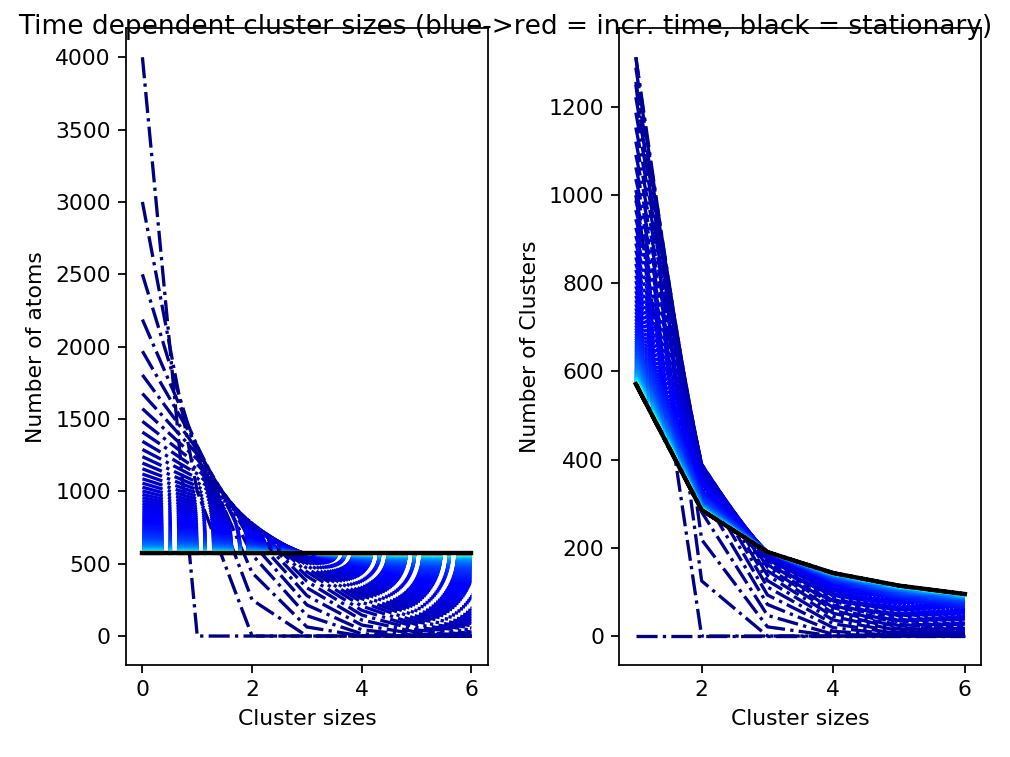

In [4]:
# number of atoms that can be distributed among the clusters
Natoms = 4000

# cluster sizes and initial distribution (no clusters here yet)
cluster_sizes = np.arange(7)
print("\ncluster_sizes:\n",cluster_sizes)

initial_distribution = np.zeros(cluster_sizes.shape[0])
initial_distribution[0] = 1
print("\ninitial_distribution:\n",initial_distribution)

# setup of transition matrix
c = np.zeros(cluster_sizes.shape[0])
c[0] = .5
c[1] = .25

# transition matrix
A = toeplitz(c)
A[0,0] += c[0]-c[1]
A[-1,-1] += c[0]-c[1]

# normalizing the transition matrix
A /= A.sum(axis=1)
print("\nTransition matrix:\n",A)

# testing transition matrix for validity
w, v = np.linalg.eig(A)
idx_first_eigenval = np.where(np.isclose(w,1))[0]
first_eigenvec = v[:,idx_first_eigenval]
first_eigenvec_n = first_eigenvec / first_eigenvec.sum()
second_eigenval = np.sort(w)[-2]
print("\neigenvalues:\n",w)
print("\nsecond largest eigenvalue: ",second_eigenval," delta = ",-1./np.log(second_eigenval))
print("\neigenvectors:\n",v)
print("\nnormed eigenvector with eigenvalue == 1:\n",first_eigenvec_n)
print("\nTransition matrix times normed eigenvector with eigenvalue == 1:\n",np.dot(A,first_eigenvec_n))

n = 1000
lim = np.copy(initial_distribution)
for i in range(n):
    lim = np.dot(A,lim)
    lim /= lim.sum()
print("\nasymptotic limit A**",n," * initial_distribution =\n",lim,"\n    sum = ",lim.sum())
assert np.isclose(first_eigenvec_n.sum(),1), "Invalid transition matrix! Normed leading eigenvector = {} != 1".format(first_eigenvec_n)

# time evolution
Nsteps = 250

# run simulation
atom_distributions = np.zeros((Nsteps+1,cluster_sizes.shape[0]))
atom_distributions[0,:] = initial_distribution

dis = np.copy(initial_distribution)
for i in range(Nsteps):
    if i%10==0:
        print("{}/{}".format(i+1, Nsteps))
    dis = np.dot(A, dis)
    dis /= dis.sum()
    atom_distributions[i+1,:] = dis
    #atom_distributions[i+1,:] = dis * Natoms
    
    # testing the conservation of numbers additionally to the eigenvalue test, just to be safe
    assert np.isclose(atom_distributions[i+1,:].sum(), 1), "Conservation of numbers violated! {} != {}".format(1,atom_distributions[i+1,:].sum())
atom_distributions *= Natoms
cluster_distributions = atom_distributions[:,1:] / cluster_sizes[1:]

stationary_atoms_distribution = np.reshape(first_eigenvec_n * Natoms, (-1,))
stationary_cluster_distribution = stationary_atoms_distribution[1:] / cluster_sizes[1:]
print("cluster_sizes ",cluster_sizes.shape)
print("stationary_atoms_distribution ",stationary_atoms_distribution.shape)
print("stationary_cluster_distribution ",stationary_cluster_distribution.shape)

fig = plt.figure()
ax = fig.add_subplot(121)
for i,dis in enumerate(atom_distributions):
    ax.plot(cluster_sizes, dis,'-.', label=str(i), color=plt.cm.jet(i/float(atom_distributions.shape[0])))
ax.plot(cluster_sizes, stationary_atoms_distribution, 'k-', label="stationary", lw=2.)
ax.set_xlabel("Cluster sizes")
ax.set_ylabel("Number of atoms")
#plt.legend(loc=0)

ax2 = fig.add_subplot(122)
for i, cdis in enumerate(cluster_distributions):
    ax2.plot(cluster_sizes[1:], cdis, '-.', label=str(i), color=plt.cm.jet(i/float(cluster_distributions.shape[0])))
ax2.plot(cluster_sizes[1:], stationary_cluster_distribution, 'k-', label="stationary", lw=2.)
ax2.set_xlabel("Cluster sizes")
ax2.set_ylabel("Number of Clusters")
plt.suptitle("Time dependent cluster sizes (blue->red = incr. time, black = stationary)")
plt.tight_layout()
plt.show()

### 2.2 Modelling the Dynamics of Cluster-Size Distributions

Modelling the time evolution with the diffusion equation and optimizing the parameters.

c = [ 0.  0.  0.  0.  0.  0.  0.]
d = [ 1.  1.  1.  1.  1.  1.  1.]


<IPython.core.display.Javascript object>


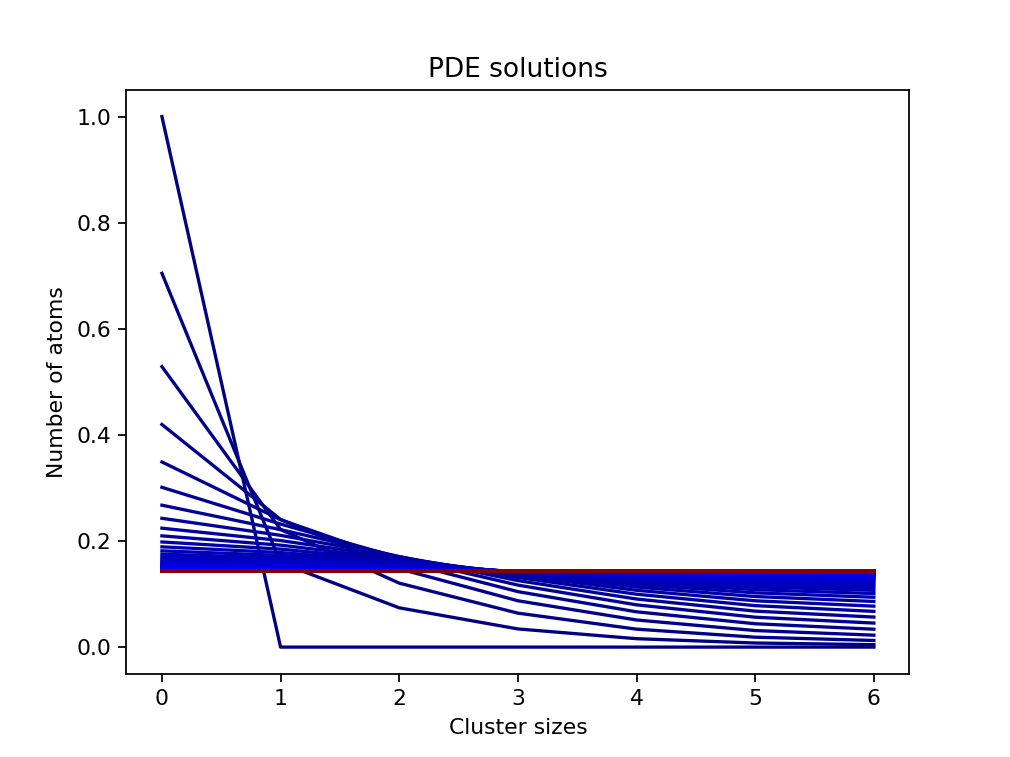

c = [  2.81638393e-08   2.04687394e-05   4.32918774e-05   4.29062653e-05
   4.28999465e-05   1.04191467e-05   4.95380865e-06]
d = [ 1.00009195  1.00008205  1.00006329  1.00004606  1.00002922  1.00002306
  1.00001178]


<IPython.core.display.Javascript object>


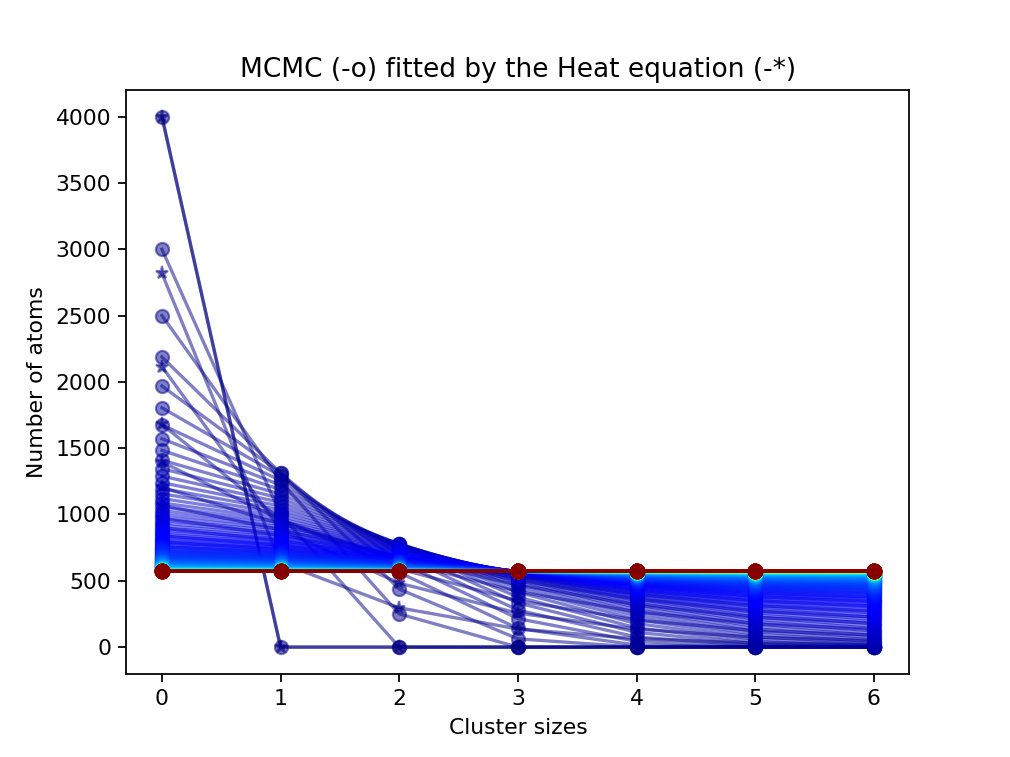

In [5]:
J = cluster_sizes.shape[0]
c = np.zeros(J) #0
d = np.ones(J) #1.

print("c = {}\nd = {}".format(c,d))
cluster_sizes_pde, atom_distributions_pde, (c, d) = atb.diffusion_solver(cluster_sizes, atom_distributions,c=c, d=d, pde_form="implicit diffusion", Nt=1, 
                 return_normalized=False, show=True, bc_left="Neumann", bc_right="Neumann", do_optimization=True, Ncluster_pad=0,
                 measure=atb.pde_measure_wrapper(atom_distributions))

print("c = {}\nd = {}".format(c,d))
fig = plt.figure()
ax = fig.add_subplot(111)
for i,y in enumerate(atom_distributions_pde):
    ax.plot(cluster_sizes_pde, y,'-*', label="pde "+str(i), color=plt.cm.jet(i/float(atom_distributions_pde.shape[0])), alpha=.5)
for i,dis in enumerate(atom_distributions):
    ax.plot(cluster_sizes, dis,'-o', label="MCMC "+str(i), color=plt.cm.jet(i/float(atom_distributions.shape[0])), alpha=.5)

ax.set_xlabel("Cluster sizes")
ax.set_ylabel("Number of atoms")
ax.set_title("MCMC (-o) fitted by the Heat equation (-*)")
plt.show()